In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
api.set_logging_level("debug")

sim = api.Simulation()
sim.set_kernel("SingleCPU")

In [2]:
sim.periodic_boundary = [True, True, True]
sim.kbt = 1.
sim.box_size = api.Vec(50., 50., 10.)

# register particle type
particle_radius = 1.0
diff = 1.5
sim.register_particle_type("B", diffusion_coefficient=diff, radius=particle_radius)
sim.register_particle_type("A", diffusion_coefficient=diff, radius=particle_radius)

# the potential that confines particles
origin = np.array([-23.,-23.,-0.001])
extent = np.array([46.,46.,0.002])
sim.register_potential_box("A", 200., api.Vec(*origin), api.Vec(*extent), False)
sim.register_potential_box("B", 200., api.Vec(*origin), api.Vec(*extent), False)

# reactions
#sim.register_reaction_fission("birth", "A", "A", "A", rate=18e-2, product_distance=2.*particle_radius)
#sim.register_reaction_enzymatic("eat", "B", "A", "B", rate=6e-2, educt_distance=2.*particle_radius)
#sim.register_reaction_decay("decay", "B", rate=3e-2)
sim.register_reaction_fission("birth", "A", "A", "A", rate=4e-2, product_distance=2.*particle_radius)
sim.register_reaction_enzymatic("eat", "B", "A", "B", rate=2e-2, educt_distance=2.*particle_radius)
sim.register_reaction_decay("decay", "B", rate=3e-2)

# add particles
rnd = np.random.uniform
for i in range(100):
    pos = origin + rnd(size=3) * extent
    sim.add_particle("A", api.Vec(*pos))
    pos = origin + rnd(size=3) * extent
    sim.add_particle("B", api.Vec(*pos))

In [3]:
# define observables and run
traj_handle = sim.register_observable_flat_trajectory(stride=100)

numbers_data = []
def append_numbers(x):
    global numbers_data
    numbers_data.append(x)
    print("A", x[0], "B", x[1])

sim.register_observable_n_particles(stride=1000, types=["A", "B"], callback=append_numbers)
    
with cl.closing(api.File("./obs-lv.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=10000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .with_skin_size(3.) \
        .configure_and_run(200000, 0.005)
    t2 = time.perf_counter()
print("Simulated", t2 - t1, "seconds")

A 100 B 100
A 108 B 95
A 118 B 94
A 155 B 87
A 174 B 78
A 194 B 79
A 236 B 74
A 272 B 73
A 319 B 77
A 369 B 80
A 427 B 88
A 496 B 107
A 553 B 125
A 635 B 142
A 680 B 179
A 733 B 228
A 767 B 313
A 739 B 429
A 690 B 531
A 603 B 626
A 540 B 689
A 454 B 764
A 352 B 839
A 278 B 875
A 205 B 870
A 150 B 841
A 114 B 787
A 96 B 724
A 89 B 660
A 81 B 589
A 72 B 516
A 63 B 464
A 62 B 410
A 53 B 366
A 58 B 319
A 62 B 283
A 73 B 246
A 80 B 205
A 89 B 187
A 87 B 175
A 99 B 161
A 104 B 142
A 126 B 127
A 144 B 117
A 166 B 109
A 200 B 101
A 231 B 95
A 255 B 96
A 296 B 107
A 332 B 108
A 404 B 108
A 472 B 116
A 551 B 132
A 585 B 169
A 656 B 187
A 737 B 239
A 783 B 313
A 764 B 419
A 721 B 554
A 639 B 672
A 568 B 773
A 417 B 886
A 313 B 923
A 244 B 939
A 185 B 902
A 145 B 849
A 107 B 781
A 88 B 703
A 76 B 627
A 72 B 538
A 60 B 464
A 60 B 416
A 51 B 375
A 54 B 341
A 58 B 307
A 68 B 263
A 69 B 235
A 67 B 204
A 73 B 179
A 80 B 152
A 82 B 137
A 90 B 125
A 107 B 114
A 125 B 105
A 141 B 99
A 156 B 94
A 184 B 90


In [4]:
# convert trajectory
t1 = time.perf_counter()
api.convert_xyz("./obs-lv.h5", "traj", "./traj-lv.xyz", radii={"A": 0.5, "B": 0.5})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Conversion took 3.64770667799894 seconds


In [5]:
numbers = np.array(numbers_data)

In [6]:
numbers.shape

(201, 2)

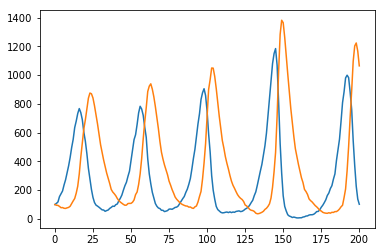

In [9]:
plt.plot(numbers[:,0])
plt.plot(numbers[:,1])
plt.show()

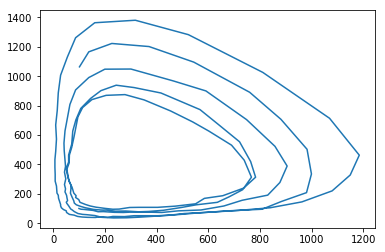

In [10]:
plt.plot(numbers[:,0], numbers[:,1])
plt.show()